In [1]:
import tensorflow as tf

from keras import backend as K

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import Adam, SGD

from keras.applications.resnet50 import preprocess_input

from keras.callbacks import ReduceLROnPlateau

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import numpy as np

import pandas as pd

import os

Using TensorFlow backend.


In [2]:
import types
import matplotlib
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
            try:
                yield val.__version__
            except:
                pass
list(imports())

['builtins',
 'builtins',
 'tensorflow',
 '1.13.1',
 'keras.backend',
 'matplotlib.pyplot',
 'matplotlib.image',
 'numpy',
 '1.16.5',
 'pandas',
 '0.25.1',
 'os',
 'types',
 'matplotlib',
 '3.1.1']

In [3]:
tf.logging.set_verbosity(tf.logging.ERROR)

## Gobal parameters

In [4]:
# Fixed for our Hot Dog & Pizza classes
NUM_CLASSES = 2

# Class names
HOT_DOG_CLASS_NAME = "hot_dog"
PIZZA_CLASS_NAME = "pizza"

# Classification type
CLASSIFICATION_TYPE = 'binary'

# Fixed for Hot Dog & Pizza color images
CHANNELS = 3

# AlexNet specific input image size
IMAGE_RESIZE = 227

# Padding strategy to keep the same image size
SAME_PADDING = 'same'

# Padding strategy with right and bottom crop
VALID_PADDING = 'valid'

# Pooling strategy
RESNET50_POOLING_AVERAGE = 'avg'

# Activation functions
CONVOLUTIONAL_LAYER_ACTIVATION = 'relu'
DENSE_LAYER_ACTIVATION = 'sigmoid'

# Used to evaluate the error
OBJECTIVE_FUNCTION = 'binary_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 3
EARLY_STOP_PATIENCE = 2

# Batch sizes for training and validation
BATCH_SIZE_TRAINING = 128
BATCH_SIZE_VALIDATION = 64

# Generate images
GENERATION_RATIO = 1
TOTAL_GENERATED_IMAGES = 1500

# Steps for each epoch
STEPS_PER_EPOCH_TRAINING = TOTAL_GENERATED_IMAGES / BATCH_SIZE_TRAINING
STEPS_PER_EPOCH_VALIDATION = 300 / BATCH_SIZE_VALIDATION

# Using 1 to easily manage mapping between test_generator & prediction
BATCH_SIZE_TESTING = 1

# Work directory to save the checkpoints
WORK_FOLDER = 'working'

# Checkpoint file name
CHECKPOINT_FILE = 'best.hdf5'

# Automatic save and replace mode of the weights
MODEL_CHECKPOINT_MODE = 'auto'

# The metrics that we want to monitor
LOSS_MONITOR = 'val_loss'

# Weights file name
WEIGHTS_FILE = 'best_weights.h5'

## Folder paths

In [5]:
# Base folder path for the Hot Dog & Pizza classification images
BASE_FOLDER_PATH = os.path.join('datasets', 'hotdog_pizza')

# The path to the training images
TRAIN_FOLDER_PATH = os.path.join(BASE_FOLDER_PATH, 'train')

# The path to the validation images
VALIDATION_FOLDER_PATH = os.path.join(BASE_FOLDER_PATH, 'valid')

# The path to the test images
TEST_FOLDER_PATH = os.path.join(BASE_FOLDER_PATH, 'test')

# Checkpoint file path
CHECKPOINT_FILE_PATH = os.path.join(WORK_FOLDER, CHECKPOINT_FILE)

# Weights file path
WEIGHTS_FILE_PATH = os.path.join(WORK_FOLDER, WEIGHTS_FILE)

# Generated train image paths
GENERATED_IMAGE_FOLDER_PATH = os.path.join(BASE_FOLDER_PATH, 'generated')

## Helper function to load and resize the images

In [6]:
read = lambda image_name: np.asarray(load_img(image_name, target_size=(IMAGE_RESIZE, IMAGE_RESIZE)))

def read_images(image_path):
    image_names = os.listdir(image_path)
    image_paths = [os.path.join(image_path, image_name) for image_name in image_names]
    images = np.array([read(image_path) for image_path in image_paths], dtype='uint8')
    return images

## Helper function to show the classification results and the confidence

In [7]:
def predict_class(model, image):
    scaled_image = image/255.
    y_pred = model.predict_classes([[scaled_image]])
    confidence = model.predict([[scaled_image]])
    print("Predicted class:")
    
    if y_pred[0][0] == 1:
        print(PIZZA_CLASS_NAME)
    else:
        print(HOT_DOG_CLASS_NAME)
    
    print(y_pred[0][0])
    
    print("Confidence:")
    print(confidence[0][0])

## Helper function to visualize the training process history

In [8]:
def plot_training_history(fit_history):
    training_accuracy_key = 'acc'
    training_loss_key = 'loss'
    
    test_accuracy_key = 'val_acc'
    test_loss_key = 'val_loss'
    
    diagrams_x_label = 'epoch'
    
    accuracy_diagram_title = 'model accuracy'
    accuracy_diagram_y_label = 'accuracy'
    
    loss_diagram_title = 'model loss'
    loss_diagram_y_label = 'loss'
    
    legend_labels = ['train', 'test']
    legend_position = 'upper left'
    
    # list all data in history
    print(fit_history.history.keys())
    
    # summarize history for accuracy
    plt.plot(fit_history.history[training_accuracy_key])
    plt.plot(fit_history.history[test_accuracy_key])
    plt.title(accuracy_diagram_title)
    plt.ylabel(accuracy_diagram_y_label)
    plt.xlabel(diagrams_x_label)
    plt.legend(legend_labels, loc=legend_position)
    plt.show()
    
    # summarize history for loss
    plt.plot(fit_history.history[training_loss_key])
    plt.plot(fit_history.history[test_loss_key])
    plt.title(loss_diagram_title)
    plt.ylabel(loss_diagram_y_label)
    plt.xlabel(diagrams_x_label)
    plt.legend(legend_labels, loc=legend_position)
    plt.show()

## Helper function to generate synthetic training images

In [9]:
def augment_train_images(image, current_index, folder_name, multiplication_factor=4):
    data = img_to_array(image)
    # expand dimension to one sample
    samples = np.expand_dims(data, 0)
    # create image data augmentation generator
    datagen = ImageDataGenerator(rotation_range=180)
    # prepare iterator
    it = datagen.flow(samples, batch_size=1, shuffle=False)
    # generate samples and plot
    for i in range(multiplication_factor):
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype('uint8')
        mpimg.imsave(os.path.join(GENERATED_IMAGE_FOLDER_PATH, folder_name, "" + str(current_index) + str(i) + '.png'), image)

## Helper function to plot image grid and classification results

In [10]:
def plot_image(base_path, images, image_count, labels, image_width=18, image_height=12):
    fig=plt.figure(figsize=(image_width, image_height))
    
    columns = 10
    rows = image_count // columns

    for i in range(1, columns*rows + 1):
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(labels[i])
        img = read(os.path.join(base_path, images[i]))
        plt.imshow(img)

## Visualize input images

In [11]:
hot_dog_class_path = os.path.join(TRAIN_FOLDER_PATH, HOT_DOG_CLASS_NAME)

In [12]:
hot_dog_images = read_images(hot_dog_class_path)

In [13]:
hot_dog_images[0].shape

(227, 227, 3)

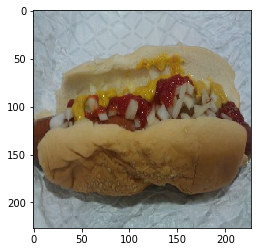

In [14]:
plt.imshow(hot_dog_images[45])

In [15]:
pizza_class_path = os.path.join(TRAIN_FOLDER_PATH, PIZZA_CLASS_NAME)

In [16]:
pizza_images = read_images(pizza_class_path)

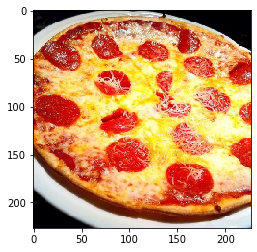

In [17]:
plt.imshow(pizza_images[25])

## Build the CNN model

In [18]:
#Instantiate an empty model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding=VALID_PADDING))
model.add(Activation(CONVOLUTIONAL_LAYER_ACTIVATION))
# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding=VALID_PADDING))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding=SAME_PADDING))
model.add(Activation(CONVOLUTIONAL_LAYER_ACTIVATION))
# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding=VALID_PADDING))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding=SAME_PADDING))
model.add(Activation(CONVOLUTIONAL_LAYER_ACTIVATION))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding=SAME_PADDING))
model.add(Activation(CONVOLUTIONAL_LAYER_ACTIVATION))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding=SAME_PADDING))
model.add(Activation(CONVOLUTIONAL_LAYER_ACTIVATION))
# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding=VALID_PADDING))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(4096, input_shape=(227*227*3,)))
model.add(Activation(CONVOLUTIONAL_LAYER_ACTIVATION))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation(CONVOLUTIONAL_LAYER_ACTIVATION))
# Add Dropout
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(1))
model.add(Activation(DENSE_LAYER_ACTIVATION))

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
activation_2 (Activation)    (None, 27, 27, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)       885120    
__________

## Setup the optimizers for the training phase

In [20]:
lr = 1e-3
adam_optimizer = Adam(lr=lr)
#sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)

## Compile our model

In [21]:
model.compile(optimizer=adam_optimizer, loss=OBJECTIVE_FUNCTION, metrics=LOSS_METRICS)

## Augment our image dataset with synthetic images

In [22]:
for i in range(len(hot_dog_images)):
    augment_train_images(hot_dog_images[i], i, 'hot_dog', GENERATION_RATIO)

In [23]:
for i in range(len(pizza_images)):
    augment_train_images(pizza_images[i], i, 'pizza', GENERATION_RATIO)

## Setup the input data (image) generators

In [29]:
train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                    rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)

validation_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                    rescale=1./255)

train_generator = train_data_generator.flow_from_directory(
        GENERATED_IMAGE_FOLDER_PATH,
        target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode=CLASSIFICATION_TYPE,
        shuffle=True)

validation_generator = validation_data_generator.flow_from_directory(
        VALIDATION_FOLDER_PATH,
        target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode=CLASSIFICATION_TYPE,
        shuffle=True)

Found 1500 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [30]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(128, 12, 64, 5)

## Setup the callbacks used during the training process

In [31]:
cb_early_stopper = EarlyStopping(monitor = LOSS_MONITOR, patience = EARLY_STOP_PATIENCE)

cb_checkpointer = ModelCheckpoint(filepath = CHECKPOINT_FILE_PATH, monitor = LOSS_MONITOR, save_best_only = True, mode = MODEL_CHECKPOINT_MODE)

learning_rate_reduction = ReduceLROnPlateau(monitor=LOSS_MONITOR, 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

## Train our model

In [32]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, learning_rate_reduction],
        verbose=1
)

Epoch 1/3
12/11 [==============================] - 122s 10s/step - loss: 1.2736 - acc: 0.5347 - val_loss: 0.6975 - val_acc: 0.5000
Epoch 2/3
12/11 [==============================] - 112s 9s/step - loss: 0.6893 - acc: 0.5640 - val_loss: 0.6630 - val_acc: 0.6067
Epoch 3/3
12/11 [==============================] - 115s 10s/step - loss: 0.6730 - acc: 0.6147 - val_loss: 0.6515 - val_acc: 0.6567


## Reload the best weigths found during the training process

In [33]:
model.load_weights(CHECKPOINT_FILE_PATH)

## Visualize the training process history

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


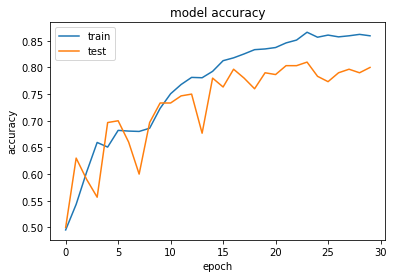

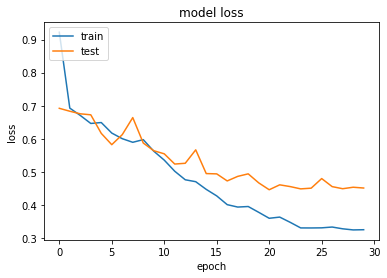

In [26]:
plot_training_history(fit_history)

## Testing the trained model

### Read the test images

In [34]:
pizza_test_path = os.path.join(TEST_FOLDER_PATH, PIZZA_CLASS_NAME)
hot_dog_test_path = os.path.join(TEST_FOLDER_PATH, HOT_DOG_CLASS_NAME)

In [35]:
pizza_test_images = read_images(pizza_test_path)
hot_dog_test_images = read_images(hot_dog_test_path)

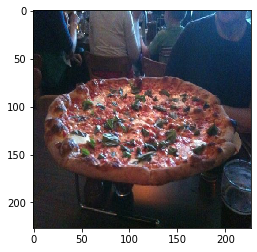

In [36]:
plt.imshow(pizza_test_images[7])

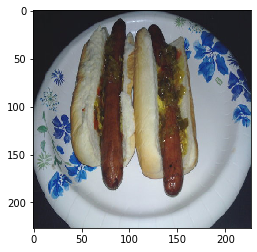

In [37]:
plt.imshow(hot_dog_test_images[17])

### Classify images

In [38]:
predict_class(model, hot_dog_test_images[5])

Predicted class:
hot_dog
0
Confidence:
0.078784086


In [39]:
predict_class(model, pizza_test_images[2])

Predicted class:
hot_dog
0
Confidence:
0.11282194


### Visualize multiple results

In [40]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)

In [41]:
test_generator = data_generator.flow_from_directory(
    directory = TEST_FOLDER_PATH,
    target_size = (IMAGE_RESIZE, IMAGE_RESIZE),
    batch_size = BATCH_SIZE_TESTING,
    class_mode=CLASSIFICATION_TYPE
)

Found 200 images belonging to 2 classes.


In [42]:
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

200/200 [==============================] - 14s 70ms/step


In [43]:
labels = ["Pizza" if pred[i] >= 0.5 else "Hot Dog" for i in range(len(pred))]

In [44]:
pred

array([[0.5149759 ],
       [0.39838552],
       [0.4022902 ],
       [0.41753173],
       [0.42541414],
       [0.5532218 ],
       [0.4736243 ],
       [0.46809888],
       [0.5248412 ],
       [0.41091388],
       [0.49349678],
       [0.42823154],
       [0.52739275],
       [0.3766902 ],
       [0.41666904],
       [0.48352993],
       [0.52630633],
       [0.30833745],
       [0.5727987 ],
       [0.47851422],
       [0.55132085],
       [0.5703995 ],
       [0.49285668],
       [0.45965716],
       [0.40099487],
       [0.48073062],
       [0.38005736],
       [0.3262952 ],
       [0.5912213 ],
       [0.5219318 ],
       [0.5025792 ],
       [0.5000685 ],
       [0.47429553],
       [0.52982074],
       [0.4475376 ],
       [0.4811864 ],
       [0.5793883 ],
       [0.47446468],
       [0.37987742],
       [0.40727866],
       [0.4331184 ],
       [0.48565257],
       [0.4913851 ],
       [0.4794857 ],
       [0.4293683 ],
       [0.5904653 ],
       [0.51565534],
       [0.392

In [45]:
labels

['Pizza',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Pizza',
 'Hot Dog',
 'Hot Dog',
 'Pizza',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Pizza',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Pizza',
 'Hot Dog',
 'Pizza',
 'Hot Dog',
 'Pizza',
 'Pizza',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Pizza',
 'Pizza',
 'Pizza',
 'Pizza',
 'Hot Dog',
 'Pizza',
 'Hot Dog',
 'Hot Dog',
 'Pizza',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Pizza',
 'Pizza',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Pizza',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Pizza',
 'Pizza',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Pizza',
 'Hot Dog',
 'Pizza',
 'Hot Dog',
 'Hot Dog',
 'Pizza',
 'Pizza',
 'Hot Dog',
 'Hot Dog',
 'Pizza',
 'Hot Dog',
 'Hot Dog',
 'Pizza',
 'Hot Dog',
 'Pizza',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Pizza',
 'Pizza',
 'Hot Dog',
 'Pizza',
 'Pizza',
 'Hot Dog',
 'Hot Dog',
 'Hot Dog',
 'Pizza',
 'Hot Dog',
 'Hot 

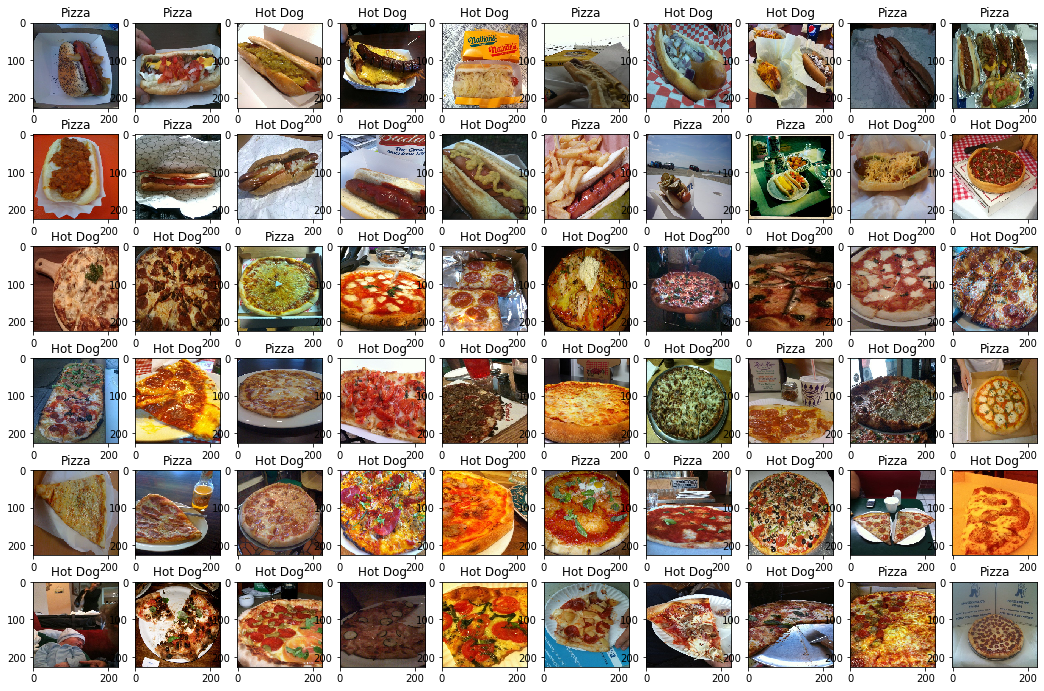

In [46]:
start_index = 80
end_index = 141
count = end_index - start_index - 1
plot_image(TEST_FOLDER_PATH, test_generator.filenames[start_index:end_index], count, labels[start_index:end_index])